# Simple specimen solutions to Activities

This notebook provides a set of possible, simple solutions to SXPS288 Python Activities.

These are not the most sophisticated solutions possible (there is pretty much no error checking) nor are they the only ones possible. They just provide a guide and are here to assist in supporting students who may have trouble in completing them.

They should not be provided 'as is' to students, although it may be suitable to give out the odd snippet.

# ARROW - Week 1- 7


## Activities 3.1, 3.2 and 3.3

Solutions are actually fully provided in the notebook **"Early_ARROW_Python_exercises"**

## Activity 4.2 - Target visibility using Python

Most of the code is already available in the 'astropy' notebook. Also note that Stellarium provides a way to do this exercise - so not a disaster if a student can't cope.

This is a fairly full that loops through a selection of 'l' values and produces a 'pretty' table. Most of this isn't required and a simple single input 'l' would be fine.


In [ ]:
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy.time import Time
from astropy import units as u

#obs_date = input('Enter observing date in format yyyy-mm-dd ')
#obs_time = input('Enter observing start time (UTC) in format hh:mm:ss ')

# Here, you could check for a correct format using regex to isolate yyyy, mm, dd, hh, mm, ss

# For debuging purposes (I've put in some fixed values - it's easier than inputing values 
# every time it's run 
obs_date = '2019-12-15'
obs_time = '03:30:00'

#ARROW location. THis is actually done in section 4.2 of the UsingAstropy notebook
ARROW = EarthLocation(lat=52.024444*u.deg, \
                   lon=-0.706388*u.deg, \
                   height=114*u.m)
# Set up date/time in correct format (mostly in section 4.1 of UsingAstropy)
obs_str=obs_date+'T'+obs_time
obs = Time(obs_str, format='isot', scale='utc')


# The next bit is pretty much covered in section 4.3 of UsingAstropy. I've added a 
# loop and produced a table - you could just prompt for 'l' and 'b' each time.

# Print output 'table' intro and headings
# NOTE '\t' is a TAB character, '\n' is a NEWLINE character
print('These are the computed Alt/Az values (all in degrees)')
print('A \'+\' in the \'OK\' column indicates a target is visible \n')
print ('\t l      Alt     Az   OK?')
print ('\t=========================')


# We're on the Galactic plane so ...
b=0

# Loop through a selection of Galactic longitudes
for l in range(20, 250, 10):
    # Get coordiantes
    target = SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic')
    # Do conversions
    ARROW_frame=AltAz(obstime=obs, location=ARROW)
    ARROW_altaz=target.transform_to(ARROW_frame)
    
    ARROW_alt = ARROW_altaz.alt.deg
    ARROW_az = ARROW_altaz.az.deg
    # Could do some checking
    ok=''
    if ARROW_alt>20 and ARROW_alt<80 and ARROW_az>20 and ARROW_az<340:
        ok='+'
    else:
        ok='-'
    # Print out each target line using 'f string' formating
    print(f'\t {l:3d}   {ARROW_alt:5.1f}   {ARROW_az:5.1f}   {ok}')

## Activity 5.1 Displaying your own data

Just allows the student to display and inspect an ARROW spectrum. 

You could do this with Matplotlib, but using Bokeh allows a little more information to be displayed. If now, or later (specifically Activity 6.2) it is useful to put the display code within a loop in a notebook, Bokeh is much easier to use. This is all covered in the Bokeh notebook.

You could read the data into numPy arrays but pandas is just as easy and later will prove to be more useful.

ARROW spectra contain 12 'header' lines of 'comments' which contain useful information about the observation. In this activity this information is not needed but it will be in the next Activity.


In [ ]:
import pandas as pd
from bokeh.plotting import figure, output_notebook, show
from bokeh.models.tools import HoverTool

number_header_lines=12
#file_name = input('Enter spectrum file name ')
file_name = '080-orig.csv' # For debugging purposes to save typing

# Read in the data - note we skip over the header lines
spectrum_df = pd.read_csv(file_name, header=number_header_lines)

# Display it.
# Note the addition of a 'HoverTool' which gives interactive information of any
# data point near the cursor. This is not vital here but is essential in later Activities.

output_notebook() # Needed to display the figure 'inline'

p = figure(title = "An ARROW spectrum", 
          x_axis_label='Frequency (Hz)', 
          y_axis_label='Intensity')
p.line(spectrum_df['frequency'], spectrum_df['intensity'])
p.add_tools(HoverTool(mode='vline'))
show(p)

## Activity 5.2 Processing your spectra and Activity 5.3 Plot your processed spectra

Here we begin to process the data, converting from frequency offsets to radial velocity.

1. We read in the data BUT we have to keep the header data for later as it contains information required for the LSR corrections, We will need to add it back into a new file containing radial velocity data.
2. Aggregate the background spectra and subtract from the actual data to remove the spectrum baseline slope.
3. Calculate the velocities using the Doppler equation
4. Display the spectrum to make sure all is well
5. Re-write the spectrum to disk, but now containing the velocity information.

In the example below a number of helper functions have been written. This isn't necessary and the code could be placed in the main code. We've done this because it's the type of code that might be useful as a block elsewhere. 

Probably most critically, we've provided a function that will read in the spectrum, separate the header information and return these along with a pandas DataFrame of the data. 

The function that takes the input file name and provide s new output file name is really not essential - you could just prompt the user for a new name. 

We'll use matplotlib to display the spectrum - bokeh would work just as well.

The stuents are given the DataProcessing notebook that covers most of this.


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import re # Optional for the gen_file_name() function


# Read in the data
def read_ARROW_data(filename):
    """Reads in and partially processes an  ARROW spectrum
    
    The spectrum file contains a number of header lines indicated by `#' or blanks. 
    This function splits these from the main data and returns both 
            
    Parameters
    ----------
    filename : str
        Name of the spectrum file
    
    Returns
    -------
    dat : class: pandas.DataFrame
        Spectrum data
    Header lines : list of str
        List of header lines
    """
    
    # Read lines till first line not starting with #, or whitespace.
    # Store these as a list
    header_list=[]
    number_header_lines=0
    dat=None
    with open(filename) as f:
        line = f.readline()
        while line[0] == '#' or line[0] == ',' or line[0].isspace():
            header_list.append(line)
            number_header_lines += 1
            line = f.readline()
        dat = pd.read_csv(filename, header=number_header_lines)

    return dat, header_list

# OPTIONAL A Function to convert frequency to radial velocity. 
def freq_to_vel(freq, f0=1420.4e6):
    ''' Takes a frequency value (or Pandas Dataframe column or Series) and returns
    a velocity value (km/s) (or new Dataframe column of values). f0 is the rest
    frequency and defaults to 1420.4 MHz'''
    
    # We need a value for 'c' - speed of light. Either just do it here or, neatly, use the 
    # astropy 'constants'
    c = 299792458.0  #m/s
    
    v = v = -c*(freq)/(freq+f0)
    return v/1000  #(km/s)          

# OPTIONAL A simple function to generate a new name for the velocity/intensity file.
# Could just prompt user for a new name.
def gen_file_name(f_name):
    ''' Just adds "-vel" to file name before ".csv"'''
    return f_name.replace(".", "-vel.")

#====================#
# START OF MAIN CODE #
#====================#

#file_name = input('Enter spectrum file name ')
file_name = '080-orig.csv' # For debugging purposes to save typing

# use the function to get the data
spectrum_df, header_lines = read_ARROW_data(file_name)

# Display the first few lines
spectrum_df.head(4)

This next bit removes the base line. It is really horrible code - you shouldn't need to hard-code in file names like this. However, it is simple and therefore caters for the least confident coders. Following this block is the code for a much better solution

In [ ]:
# Read in the background spectra, average and subtract from the spectrum
# Here we use  'hard-wired' file names but you could, and probably should, use a file 
# list, or manually enter them.
bg1 = pd.read_csv('bg1.csv', header=number_header_lines)
bg2 = pd.read_csv('bg2.csv', header=number_header_lines)
bg3 = pd.read_csv('bg3.csv', header=number_header_lines)

# Compute average 'intensity' values
bg_av = (bg1['intensity']+bg2['intensity']+bg3['intensity'])/3

# Subract from spectrum 'intensity'
spectrum_df['intensity'] = spectrum_df['intensity']-bg_av.values

Here is a better solution. Prepare a text file (with a simple text editor - NOT a word processor) containing a list of background files - one file name per line.

START OF ALTERNATIVE CODE

==================================================================================

In [ ]:
# Read in the list of files into "bg_files"
with open('bgfiles.txt') as lines:
    bg_files= lines.read().splitlines()

# Form a list containg each file's actual 'intensity' data (skip heder lines)
li=[]
for f in bg_files:
    df = pd.read_csv(f, header=12)
    li.append(df)
    
# Average these ('sum' them and divide by the number of files which is the 
#    length of the file list)
bg_av = sum(li)/len(li)
print(type(bg_av))
spectrum_df['intensity'] = spectrum_df['intensity']-bg_av['intensity'].values


================================================================================

END OF ALTERNATIVE CODE

In [ ]:
# Convert frequency to radial velocity values using this function
spectrum_v = freq_to_vel(spectrum_df['frequency'])

# Add a new 'velocity' column with these values
spectrum_df['velocity'] = spectrum_v

# Plot it out as a check 
plt.plot(spectrum_df['velocity'], spectrum_df['intensity'])
plt.xlabel('Radial Velocity (km/s)')
plt.ylabel('Intensity')

# Bokeh version - but note you'd need to import different things
#output_notebook()
#p = figure(title = "Put your Title here", 
#          x_axis_label='Velocity (kms^-1)', 
#          y_axis_label='Intensity')
#p.line(DataFrame x values, DataFrame y values)
#show(p)

# Write it out to a new file.
# The 'file_name' was user input earlier
# Here, gen_file_name() is the function we defined earlier which is used to generate a new file
# name. You could just as easily prompt the user for a new name.
new_file_name = gen_file_name(file_name) 

# First write the header lines that we read in earlier to the file
with open(new_file_name, "w") as f:
    f.writelines(header_lines)
    
# Now append the modified csv data
# NOTE we just 'append' the data - otherwise we would overwtite the header lines
spectrum_df.to_csv(new_file_name, index=False, mode='a')

## Activity 5.4 Measuring speeds from your own data

This is essentially identical to 4.1 (using HoverTool) but using the file(s) output from 4.2 - and actually noting some information down

## Activity 6.2 Plotting and measuring speeds from archived data

Once again, this is similar to 4.1 and 5.4 - except there is more than one data column in the archived spectra file. The UsingBokeh notebook contains pretty much all of the actual code needed.

This solution usese Bokeh in conjunction with pandas dataframes, but numPy arrays or plain Python lists should work just fine.

NOTE: clear_output() from a module called IPython just gives the ability to clear plots from the Jupyter notebook. Not necessary but neater.

The two lines:

`from IPython.core.interactiveshell import InteractiveShell
 InteractiveShell.ast_node_interactivity = "all"`

Are not essential, they just allow a 'pretty' display of a pandas dataframe to be produced just by using the dataframe name/function. So just typing df.head() will produce a nicely tabulated display of the first 5 lines of the datframe - print(df.head()) will work fine without this.


In [ ]:
import pandas as pd
import numpy as np

from bokeh.plotting import figure, output_notebook, show
from bokeh.models.tools import HoverTool

from IPython.display import display, clear_output

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

output_notebook()  # Needed to get Bokeh plots in the Jupyter notebooks.

# Read in the data. Note that it contains a line which has no actual data - but does contain
# a bunch of ',' - so pandas will see this as 'null' data - expresssed as 'NaN'
df = pd.read_csv('Archive_Spectra.csv', header=1, skip_blank_lines=True)
df.head(3)
# The blank line in the csv produces a row of NaN. Either edit the file before use or:
df=df.dropna()
df.head(3)

# How many spectra have we got? It's one less than the total number of columns.
spec_no = len(df.columns)-1

# Cycle through the columns starting at column 1 
# (remember index starts at 0 - which is the velocity column)
for idx in range(1,11):
    # Get the name of the column 
    colname=df.columns[idx]
    # title with colname is not essential but does tell us what we're looking at
    p1 = figure(title = "Spectral data from column "+colname, 
          x_axis_label='Velocity (kms^-1)', 
          y_axis_label='Intensity')
    p1.line(df['km per sec'],df[colname]) #Could use column numbers an 'iloc'
    p1.add_tools(HoverTool(mode='vline'))
    show(p1)
    # Wait whilst we do the measurements by prompting for a dummy input
    input('Press enter to proceed')
    # Clear the display before starting again - otherwise we get multiple plots
    clear_output(wait=True)

## Activity 6.3 Plotting the rotation curve

After Activity 6.2, the students will need to produce a 'comma delimted' file with Vobs_max values - along with an estimate of the uncertainties.

This file should have a first line with column headings longitude, v_obs_max, v_error and subsequent lines that contain the appropriate three numerical values separated by a comma. Something like:

`longitude,v_obs_max,v_error
 0,50,5
 10,75,5
 ...`


This activity reads this, calculates R and V values and produces a rotation curve from this. Either Bokeh or matplotlib can be used for plotting - here we'll use matplotlib as error bars are easier. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# These 2 lines just allow pretty printing of a DataFrame
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Set up some basic physical values we'll need
R0 = 8.5 #kpc
V0 = 220 #km/s

# Read the data file in - here it's called 'v_vobs_max.csv'
vals_df = pd.read_csv('v_obs_max.csv')
vals_df

# Do the calculatons and add appropriate columns
vals_df['R'] = R0*np.sin(vals_df['longitude']*np.pi/180)
vals_df['V'] = vals_df['v_obs_max'] + V0*np.sin(vals_df['longitude']*np.pi/180)
vals_df['V_err'] = vals_df['v_error']
vals_df

# Plot it

#matplotlib
plt.errorbar(vals_df['R'],vals_df['V'], yerr=vals_df['v_error'], fmt='.')
plt.title("Galactic rotation curve")
plt.xlabel('Radius (kpc)')
plt.ylabel('Speed (km/s)')

# Bokeh will be something like:
#p = figure(title = "Galactic rotation curve", 
#          x_axis_label='Radius (kpc)', 
#          y_axis_label='Velocity (km/s)')
#p.circle(vals_df['R'],vals_df['V'])
#
# Add some horizonal semi-transparent grid lines
#p.ygrid.grid_line_color = 'grey'
#p.ygrid.grid_line_alpha = 0.5
#
# And the error bars:
#from bokeh.models import Whisker, ColumnDataSource
#
#src = ColumnDataSource(data=dict(
#    y=vals_df['R'],
#    lower = vals_df['V']-vals_df['V_err'],
#    upper = vals_df['V']+vals_df['V_err']))
#
#w = Whisker(base='y', lower='lower', upper='upper', line_color='black', dimension='height', source=src)
#
#p.add_layout(w)
#
#show(p)


# THIS NEXT BIT IS HIGHLY OPTIONAL
# - and for fun only as there is no realy physical reality behind the model curve, 
# You could 'fit' a curve to the data to get an smooth rotation curve

from scipy.optimize import curve_fit

# Here'e a simple mathematical curve that might fit
def gal_curve(r,C0,C1,C2):
    return C0-C1*np.exp(-C2*r)

R = vals_df['R'].values
V = vals_df['V'].values
R2 = np.linspace(0,8.5, 50)

# 'Guess' some initial parameters for the constants
c0 = [250,200,0.15]

# and fit the curve 
c,pcov = curve_fit(gal_curve,R,V,c0)

print('Optimised parameters are:', *c)

# Plot it 
plt.scatter(R2,gal_curve(R2,*c), color='red', marker='.')
plt.show()

# Activity 7.2 Mapping the outer spiral arms

This is very similar to Activity 6.3 in that the student needs to produce a comma delimited file from Activities 5.3 and 6.1 (augmented with other students data as appropriate). This contains information about cloud velocities and longitude.

This should look someything like this:

`longitude,v_obs
 30,125
 30,-5
 40,75
 40,-5
 40,-25
 ...`


This data is then used to compute cloud positions - longitude and distance.

These can then be plotted. Probably easiest to use matplotlib with a 'polar' plot for this. The UsingMatplotlib notebook does show how to do these kinds of plots.


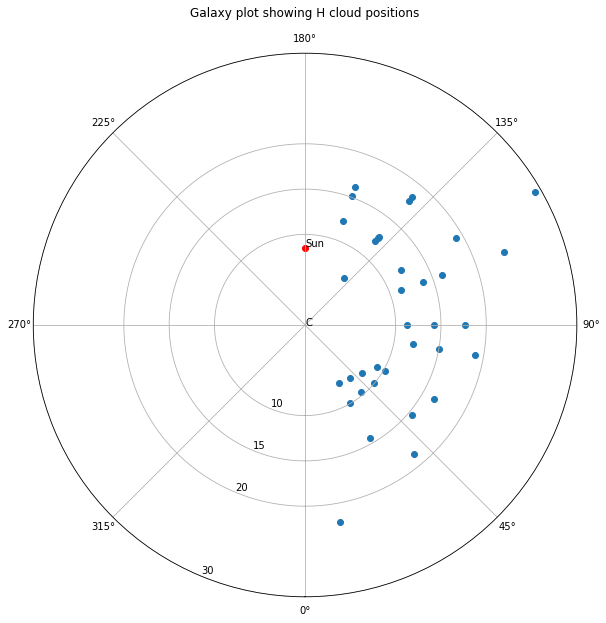

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

R0 = 8.5
V0 = 220# Use your value here 
V = 257 # Use your value here 

KPC_M = 3.08567758e+19 # kiloparsec to metre conversion factor

# Read in the data
clouds_df = pd.read_csv('cloud_v.csv')
#clouds_df.head()

# Do the calculations
# Convert to SI
R0 = R0*KPC_M
V0 = V0*1000
V=V*1000

clouds_df['R'] = V*R0/(V0 + clouds_df['v_obs']*1000/np.sin(np.deg2rad(clouds_df['longitude'])))/KPC_M
#clouds_df

# Plot it
# This version is fairly complex to get some control but a simpler version is given later

# Need angles in radians
cloud_thetas = clouds_df['longitude']*3.142/180
cloud_r = clouds_df['R']

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(111, projection='polar')
ax.scatter(cloud_thetas, cloud_r)
ax.scatter(np.deg2rad(180),8.5, marker = 'o', color='r')
ax.set_rmax(30)
ax.set_rticks([10, 15, 20, 30])  # less radial ticks
ax.set_rlabel_position(-22.5)  # get radial labels away from plotted line
ax.grid(True)
ax.annotate('Sun', xy=(np.deg2rad(180), 8.6))
ax.annotate('C', xy=(0,0.1))
ax.set_theta_zero_location('S')
ax.set_title("Galaxy plot showing H cloud positions", va='bottom')
plt.show()

# A simpler version
#plt.rcParams['figure.figsize']=[12,8]
#plt.subplot(111, projection='polar')
#plt.scatter(cloud_thetas, cloud_r)
#plt.scatter(np.deg2rad(180),8.5, marker = 'o', color='r')
#plt.ylim(0,40)
#plt.yticks([10, 15, 20, 30, 40])  # less radial ticks
#plt.annotate('Sun', xy=(np.deg2rad(180), 8.6))
#plt.annotate('C', xy=(0,0.1))
#plt.title("Galaxy plot showing H cloud positions", va='bottom')
#plt.show()
